In [0]:
from langchain_openai import ChatOpenAI
from langchain_community.tools import TavilySearchResults
from langchain_core.tools import tool
from langgraph.graph import StateGraph
from langgraph.graph.message import add_messages
from langgraph.prebuilt import ToolNode, tools_condition

from datetime import datetime
from typing import Annotated
from typing_extensions import TypedDict

from dotenv import load_dotenv
_ = load_dotenv

In [0]:
llm = ChatOpenAI(model="gpt-5.1", api_key="OPENAI_API_KEY")

In [0]:
tavily_search = TavilySearchResults(max_results=2, tavily_api_key="YOUR_TAVILY_API_KEY")

@tool
def get_current_date():
    """Return the current date and time. Use this tool first for any time-based queries."""
    return f"The current date is: {datetime('%d %B %Y')}"

In [0]:

tools = [tavily_search, get_current_date]

In [0]:
llm_with_tools = llm.bind_tools(tools)

In [0]:
class State(TypedDict):
    messages: Annotated[list, add_messages]

In [0]:
def chatbot(state: State):
    return {"message": [llm_with_tools.invoke(state["messages"])]}

In [0]:
graph_builder = StateGraph(State)

In [0]:
graph_builder.add_node("chatbot", chatbot)

In [0]:
tool_node = ToolNode(tools=tools)
graph_builder.add_node("tools", tool_node)

In [0]:
graph_builder.add_conditional_edges("chatbot", tools_condition)

In [0]:
graph_builder.add_edge("tools", "chatbot")

In [0]:
graph_builder.set_entry_point("chatbot")

In [0]:
graph = graph_builder.compile()

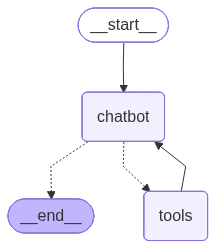

In [0]:
from IPython.display import display, Image
try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    pass

In [0]:
from IPython.display import Markdown, display

def render_markdown(md_string):
    display(Markdown(md_string))

def process_stream(stream):
    for s in stream:
        message = s["messages"][-1]
        if isinstance(message, tuple):
            print(message)
        else:
            message.pretty_print()
    return message

def process_query(query, config=None):
    inputs = {"messages": [{"role": "user", "content": query}]}
    message = process_stream(graph.stream(inputs, config, stream_mode="values"))
    render_markdown(f"## Answer:\n{message.content}")


In [0]:
process_query("Hello! What can you do ?")

================================ Human Message =================================

Hello! What can you do ?


---------------------------------------------------------------------------
RateLimitError                            Traceback (most recent call last)
File <command-4929623714803098>, line 1
----> 1 process_query("Hello! What can you do ?")

File <command-5253633435632077>, line 17, in process_query(query, config)
     15 def process_query(query, config=None):
     16     inputs = {"messages": [{"role": "user", "content": query}]}
---> 17     message = process_stream(graph.stream(inputs, config, stream_mode="values"))
     18     render_markdown(f"## Answer:\n{message.content}")

File <command-5253633435632077>, line 7, in process_stream(stream)
      6 def process_stream(stream):
----> 7     for s in stream:
      8         message = s["messages"][-1]
      9         if isinstance(message, tuple):

File /local_disk0/.ephemeral_nfs/envs/pythonEnv-0ec7b229-f273-4cd8-a881-028c230a6380/lib/python3.12/site-packages/langgraph/pregel/main.py:2646, in Pregel.stream(self, input, config, conte